In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import reverse_dict
from definitions import (
    get_node_id,
    Protein_list_Danenberg,
    Protein_list_Jackson,
    Protein_list_display_Danenberg,
    Protein_list_display_Jackson,
    Cell_types_displayed_Danenberg,
)

# Danenberg et al

In [2]:
cells = pd.read_csv('Datasets/Danenberg_et_al/cells.csv') 
cells.head()

,ImageNumber,ObjectNumber,metabric_id,meta_id,meta_description,print_order,colours,is_epithelial,isTumour,is_normal,...,CD31-vWF,CXCL12,HLA-ABC,panCK,c-Caspase3,DNA1,DNA2,Location_Center_X,Location_Center_Y,AreaShape_Area
0,1,1,MB-0282,Ep 6,CK^{med}ER^{lo},6,#40647A,True,True,0,...,0.495330,0.401104,9.282180,18.180412,0.163026,29.445302,54.989698,121.418605,4.023256,43
1,1,2,MB-0282,Ep 5,ER^{hi}CXCL12^{+},5,#99CCCC,True,True,0,...,0.552035,2.567602,1.417755,48.593726,0.310149,23.160734,42.596685,150.468531,6.083916,143
2,1,4,MB-0282,SI 3,CD4^{+} T cells & APCs,3,#F8B195,False,True,0,...,0.493669,0.117742,3.791699,3.404438,0.242591,16.884008,31.325295,221.930233,5.139535,129
3,1,5,MB-0282,Ep 6,CK^{med}ER^{lo},6,#40647A,True,True,0,...,0.373286,1.048929,2.364418,23.289196,0.297700,8.475436,15.654673,354.136364,5.890909,110
4,1,7,MB-0282,SI 2,CD4^{+} T cells,2,#FF50A2,False,True,0,...,0.287512,0.058795,4.690886,0.664581,0.078051,14.009167,28.587826,469.174603,7.158730,126


In [3]:
clinical = pd.read_csv('Datasets/Danenberg_et_al/clinical.csv')
clinical.head()


,Unnamed: 0,metabric_id,patient_id,Cohort,Overall Survival (Months),Overall Survival Status,Relapse Free Status (Months),Relapse Free Status,Chemotherapy,Radio Therapy,...,Disease-specific Survival (Months),Disease-specific Survival Status,ERStatus,ERBB2_pos,Grade,sizeOrdinal,LymphNodesOrdinal,PAM50,isDiscovery,IntClust
0,0,MB-0000,0,1.0,140.500000,0:LIVING,138.65,0:Not Recurred,NO,YES,...,138.480493,0:LIVING,pos,False,3.0,20-50mm,7+,Normal-like,True,IntClust 4+
1,1,MB-0002,2,1.0,84.633333,0:LIVING,83.52,0:Not Recurred,NO,YES,...,83.416838,0:LIVING,pos,False,3.0,5-10mm,0,Luminal A,True,IntClust 4+
2,2,MB-0005,5,1.0,163.700000,1:DECEASED,151.28,1:Recurred,YES,NO,...,161.347023,1:DECEASED,pos,False,2.0,10-20mm,1,Luminal B,True,IntClust 3
3,3,MB-0006,6,1.0,164.933333,0:LIVING,162.76,0:Not Recurred,YES,YES,...,162.562628,0:LIVING,pos,False,2.0,20-50mm,2-3,Luminal B,True,IntClust 9
4,4,MB-0008,8,1.0,41.366667,1:DECEASED,18.55,1:Recurred,YES,YES,...,40.772074,1:DECEASED,pos,False,3.0,20-50mm,7+,Luminal B,True,IntClust 9


In [4]:
print("{} patients, {} images, and {} cells".format(
    len(cells['metabric_id'].unique()), len(cells['ImageNumber'].unique()), len(cells)
)
)

718 patients, 794 images, and 1123466 cells


## Data inclusion

### 1) Exclude samples with only normal tissues and in-situ carcinoma

In [5]:
cells= cells.loc[cells.isTumour == 1]
print("{} patients, {} images, and {} cells".format(
    len(cells['metabric_id'].unique()), len(cells['ImageNumber'].unique()), len(cells)
)
)

693 patients, 749 images, and 1066966 cells


### 2) Exclude patients with clinical information missing

In [6]:

cells = pd.merge(cells, clinical, on = 'metabric_id')
print("{} patients, {} images, and {} cells".format(
    len(cells['metabric_id'].unique()), len(cells['ImageNumber'].unique()), len(cells)
)
)

683 patients, 737 images, and 1046149 cells


### 3) Exclude images with less than 500 cells

In [7]:
cells_per_image = cells.groupby('ImageNumber').size()
print(cells_per_image[:10])
cells = cells.loc[cells['ImageNumber'].isin(cells_per_image[cells_per_image > 500].index)]
print("{} patients, {} images, and {} cells".format(
    len(cells['metabric_id'].unique()), len(cells['ImageNumber'].unique()), len(cells)
)
)


ImageNumber
1     1624
2     1057
3     1648
4     1348
5     2018
6      944
7     1377
8     1535
9     1209
10    1373
dtype: int64
579 patients, 621 images, and 1016163 cells


## Discovery and inner-validation sets partition

In [8]:
random.seed(0)
Subset_id = [1] * (len(clinical) - 200) + [2] * 200
random.shuffle(Subset_id)
clinical['Subset_id'] = Subset_id
print("{} patients and {} images in the discovery set".format(
    len(clinical.loc[clinical['Subset_id'] == 1]['metabric_id'].unique()), len(cells.loc[cells['metabric_id'].isin(clinical.loc[clinical['Subset_id'] == 1]['metabric_id'])]['ImageNumber'].unique())
)
)
print("{} patients and {} images in the validation set".format(
    len(clinical.loc[clinical['Subset_id'] == 2]['metabric_id'].unique()), len(cells.loc[cells['metabric_id'].isin(clinical.loc[clinical['Subset_id'] == 2]['metabric_id'])]['ImageNumber'].unique())
)
)


2404 patients and 577 images in the discovery set
200 patients and 44 images in the validation set


## Fig.3.a. Composition and partition for the 693 patients curated by Danenberg et al

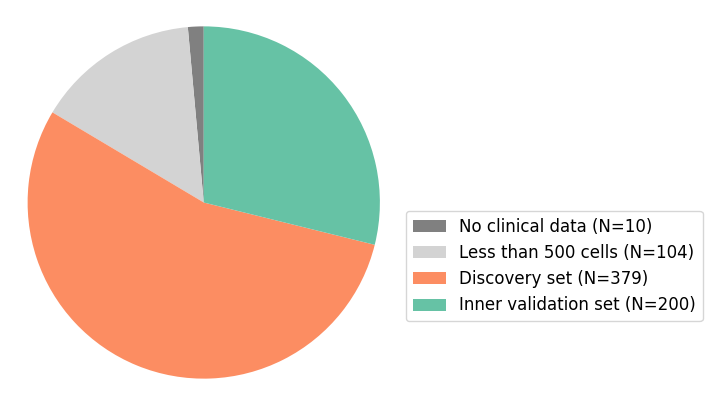

In [9]:
f, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(aspect="equal"))
labels = ['No clinical data (N=10)', 'Less than 500 cells (N=104)', 'Discovery set (N=379)', "Inner validation set (N=200)"]
sizes = [10, 104, 379, 200]
colors = ['grey','lightgrey',sns.color_palette("Set2")[1],sns.color_palette("Set2")[0]]
pie = ax.pie(sizes, labels=None,  startangle=90, colors=colors,wedgeprops=dict( linewidth=1))
ax.legend(labels, loc="upper left", bbox_to_anchor=(1, 0.5), fontsize = 12, )
# Equal aspect ratio ensures that the pie chart is circular.
plt.axis('equal')
# Show the plot
plt.show()

## Fig.A.1. The median antigen profiling of different cell phenotypes curated by Danenberg et al. 

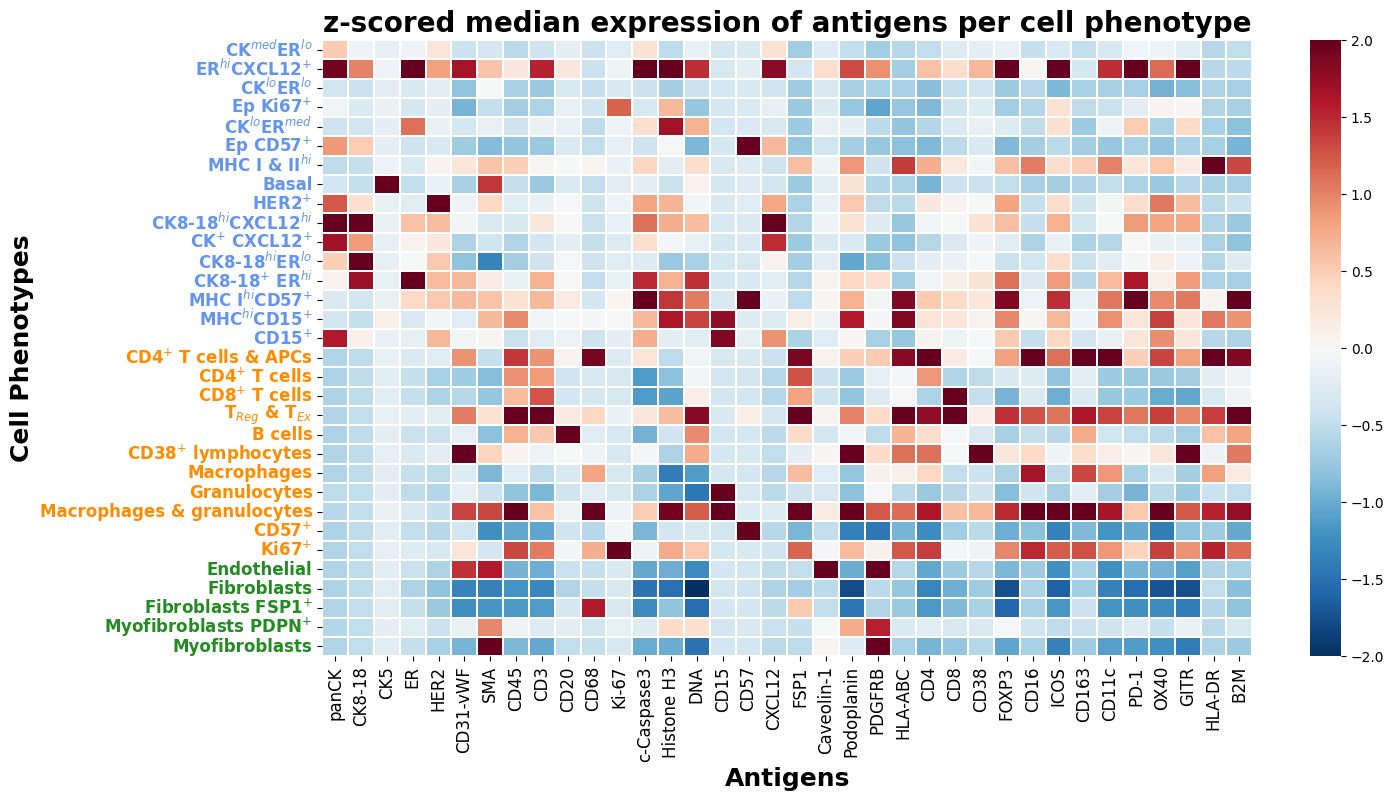

In [10]:
Cell_type_name_list = [
    reverse_dict(get_node_id("Danenberg", "CellType"))[i] for i in range(32)
]


custom_order = Cell_type_name_list
cells["meta_description"] = pd.Categorical(
    cells["meta_description"], categories=custom_order, ordered=True
)
expression_per_phenoptype = cells.groupby("meta_description")[Protein_list_Danenberg].median()
expression_per_phenoptype_scaled = (
    expression_per_phenoptype - expression_per_phenoptype.mean()
) / expression_per_phenoptype.std()


f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(
    expression_per_phenoptype_scaled,
    ax=ax,
    cmap="RdBu_r",
    center=0,
    vmin=-2,
    vmax=2,
    cbar=True,
    linewidth=0.1,
)
ax.set_xticklabels(
    Protein_list_display_Danenberg,
    fontsize=12,
)

ax.set_yticklabels(Cell_types_displayed_Danenberg, fontsize=12, fontweight="bold")
# ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12, fontweight='bold')
ax.set_xlabel("Antigens", fontsize=18, fontweight="bold")
ax.set_ylabel("Cell Phenotypes", fontsize=18, fontweight="bold")
ytickcolors = ["cornflowerblue"] * 16 + ["darkorange"] * 11 + ["forestgreen"] * 5
for ytick, color in zip(ax.get_yticklabels(), ytickcolors):
    ytick.set_color(color)
ax.set_title(
    "z-scored median expression of antigens per cell phenotype",
    fontsize=20,
    fontweight="bold",
)
f.show()

# Jackson et al

In [2]:
cells = pd.read_csv('Datasets/Jackson_et_al/cells.csv') 
cells.head()


,core,CellId,id,Location_Center_X,Location_Center_Y,cell_type,cell_type_index,EGFR,E/P-Cadherin,DNA1,...,Eccentricity,Extent,MajorAxisLength,MinorAxisLength,Number_Neighbors,Orientation,Percent_Touching,Perimeter,Solidity,meta_description_matched
0,BaselTMA_SP41_100_X15Y5,1,BaselTMA_SP41_100_X15Y5_1,13.900000,1.425000,CK low HR low,21,0.423562,5.528619,4.152675,...,0.895727,0.666667,11.471813,5.100409,3.0,5.083989,0.862069,24.702999,0.952381,CK8-18^{hi}CXCL12^{hi}
1,BaselTMA_SP41_100_X15Y5,2,BaselTMA_SP41_100_X15Y5_2,53.695652,1.130435,CK low HR low,21,0.096181,1.787632,1.952674,...,0.966755,0.766667,15.820443,4.045382,2.0,-0.070379,0.727273,30.375999,0.920000,CK^{+} CXCL12^{+}
2,BaselTMA_SP41_100_X15Y5,3,BaselTMA_SP41_100_X15Y5_3,116.678571,1.214286,CK low HR low,21,0.355950,4.178819,2.614536,...,0.882663,0.777778,9.165529,4.307864,3.0,4.051155,1.000000,19.931000,0.903226,CK8-18^{hi}ER^{lo}
3,BaselTMA_SP41_100_X15Y5,4,BaselTMA_SP41_100_X15Y5_4,125.435484,2.564516,CK low HR low,21,0.164519,3.439290,1.596000,...,0.814900,0.738095,12.312755,7.136494,5.0,19.403524,0.911765,29.367001,0.925373,CK^{med}ER^{lo}
4,BaselTMA_SP41_100_X15Y5,5,BaselTMA_SP41_100_X15Y5_5,179.328571,1.971429,CK low HR low,21,0.179570,2.686548,2.339072,...,0.922688,0.777778,15.815917,6.097788,3.0,-3.307034,0.725000,35.362999,0.921053,CK8-18^{hi}ER^{lo}


In [3]:
clinical = pd.read_csv('Datasets/Jackson_et_al/clinical.csv')
clinical.head()


,PID,core,Patientstatus,DFSmonth,OSmonth,grade,tumor_size,age,PTNM_T,PTNM_N,...,Pre-surgeryTx,Post-surgeryTx,response,Subtype,clinical_type,diseasestatus,%tumorcells,%normalepithelialcells,%stroma,%inflammatorycells
0,1,BaselTMA_SP43_1_X1Y8,death by primary disease,0.0,33.0,2,35,83,2,3,...,none,Hormone therapy,Refractory,PR+ER+,HR+HER2-,tumor,85.0,0.0,15.0,0.0
1,2,BaselTMA_SP41_2_X2Y8,alive,101.0,101.0,2,15,40,1c,1a,...,none,Chemotherapy - Tamoxifen,NaN,PR+ER+,HR+HER2-,tumor,50.0,0.0,30.0,20.0
2,3,BaselTMA_SP43_3_X13Y6,death by primary disease,23.0,23.0,3,75,63,3,0,...,none,Chemotherapy - Hormone therapy,Refractory,PR+ER+,HR+HER2-,tumor,75.0,0.0,20.0,5.0
3,4,BaselTMA_SP43_4_X15Y3,alive,63.0,63.0,1,11,49,1c,0,...,none,Tamoxifen,Sensitive,PR+ER+,HR+HER2-,tumor,80.0,0.0,20.0,0.0
4,4,BaselTMA_SP43_4_X16Y3,alive,63.0,63.0,1,11,49,1c,0,...,none,Tamoxifen,Sensitive,PR+ER+,HR+HER2-,non-tumor,0.0,30.0,70.0,0.0


In [4]:
print("{} patients, {} images, and {} cells".format(
    len(clinical['PID'].unique()), len(clinical['core'].unique()), len(cells)
)
)

285 patients, 376 images, and 855668 cells


## Data inclusion

### 1) Exclude healthy breast tissues

In [5]:
clinical = clinical[clinical['diseasestatus'] == 'tumor']
print("{} patients, {} images, and {} cells".format(
    len(clinical['PID'].unique()), len(clinical['core'].unique()), len(cells)
)
)


281 patients, 289 images, and 855668 cells


### 2) Exclude images with less than 500 cells

In [6]:
cells_per_image = cells.groupby('core').size()
print(cells_per_image[:10])
cells = cells.loc[cells['core'].isin(cells_per_image[cells_per_image > 500].index)]
cells = pd.merge(cells, clinical, on = 'core', how = 'inner')
print("{} patients, {} images, and {} cells".format(
    len(cells['PID'].unique()), len(cells['core'].unique()), len(cells)
)
)


core
BaselTMA_SP41_100_X15Y5       3558
BaselTMA_SP41_101_X10Y8       3433
BaselTMA_SP41_104_X7Y4         490
BaselTMA_SP41_104_X8Y4_175    1841
BaselTMA_SP41_104_X8Y4_233    2046
BaselTMA_SP41_106_X2Y9        2423
BaselTMA_SP41_112_X5Y8        2927
BaselTMA_SP41_114_X13Y4       2706
BaselTMA_SP41_114_X14Y4        324
BaselTMA_SP41_117_X13Y3       4572
dtype: int64
266 patients, 270 images, and 762616 cells


## Fig.3.b. Composition and partition for the 281 patients curated by Jackson et al

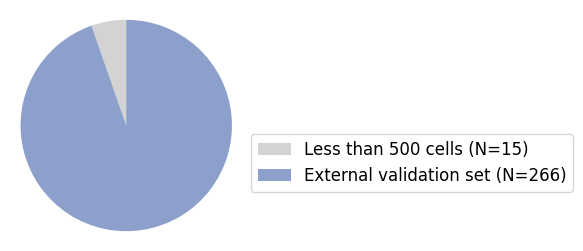

In [7]:
f, ax = plt.subplots(figsize=(3,3), subplot_kw=dict(aspect="equal"))
labels = ['Less than 500 cells (N=15)',  "External validation set (N=266)"]
sizes = [15, 266]
colors = ['lightgrey',sns.color_palette("Set2")[2]]
pie = ax.pie(sizes, labels=None,  startangle=90, colors=colors,wedgeprops=dict( linewidth=1))
ax.legend(labels, loc="upper left", bbox_to_anchor=(1, 0.5), fontsize = 12, )

# Equal aspect ratio ensures that the pie chart is circular.
plt.axis('equal')
# Show the plot
plt.show()

## Fig.A.2. The median antigen profiling of different cell phenotypes curated by Jackson et al. 

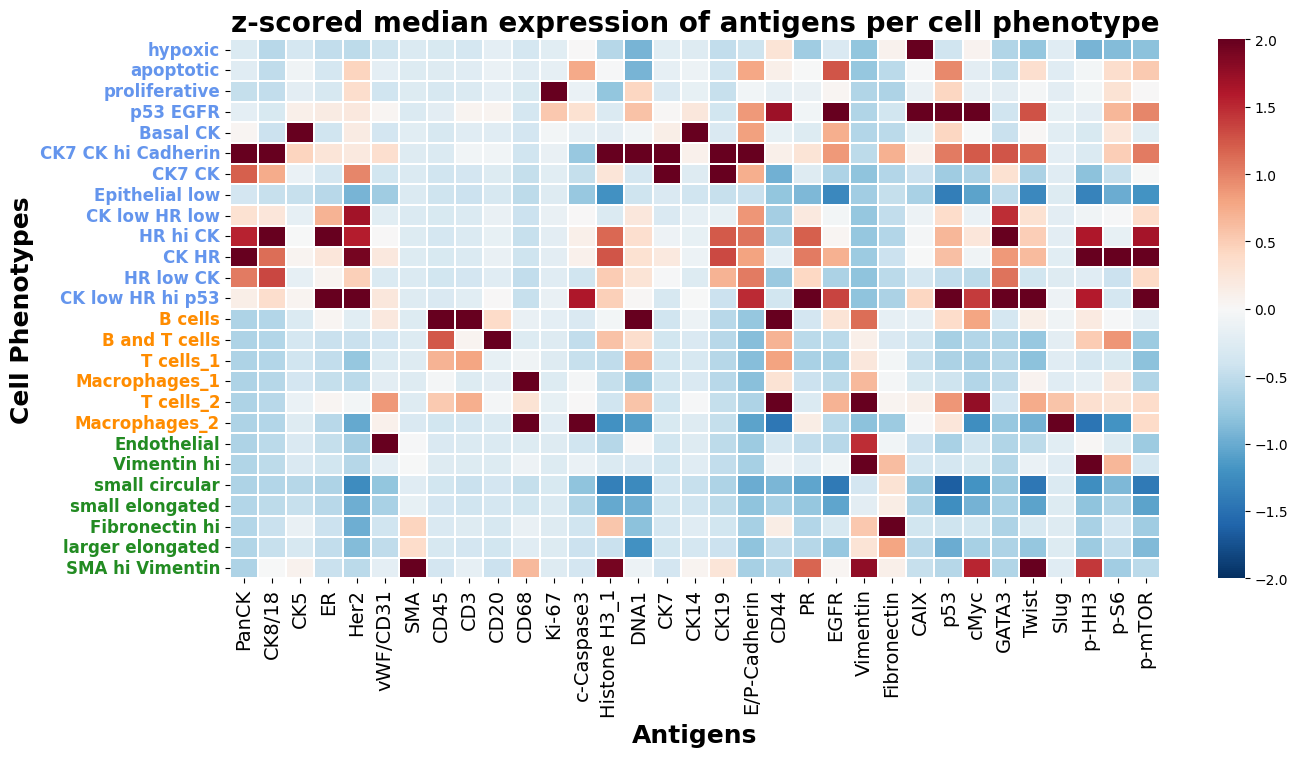

In [8]:
custom_order = [
    "hypoxic",
    "apoptotic",
    "proliferative",
    "p53 EGFR",
    "Basal CK",
    "CK7 CK hi Cadherin",
    "CK7 CK",
    "Epithelial low",
    "CK low HR low",
    "HR hi CK",
    "CK HR",
    "HR low CK",
    "CK low HR hi p53",
    "B cells",
    "B and T cells",
    "T cells_1",
    "Macrophages_1",
    "T cells_2",
    "Macrophages_2",
    "Endothelial",
    "Vimentin hi",
    "small circular",
    "small elongated",
    "Fibronectin hi",
    "larger elongated",
    "SMA hi Vimentin",
]
cells["cell_type"] = pd.Categorical(
    cells["cell_type"], categories=custom_order, ordered=True
)
expression_per_phenoptype = cells.groupby("cell_type")[Protein_list_Jackson].median()
expression_per_phenoptype_scaled = (
    expression_per_phenoptype - expression_per_phenoptype.mean()
) / expression_per_phenoptype.std()

import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(
    expression_per_phenoptype_scaled,
    ax=ax,
    cmap="RdBu_r",
    center=0,
    vmin=-2,
    vmax=2,
    cbar=True,
    linewidth=0.1,
)
ax.set_xticklabels(Protein_list_display_Jackson, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, fontweight="bold")
ax.set_xlabel("Antigens", fontsize=18, fontweight="bold")
ax.set_ylabel("Cell Phenotypes", fontsize=18, fontweight="bold")
ax.set_title(
    "z-scored median expression of antigens per cell phenotype",
    fontsize=20,
    fontweight="bold",
)
ytickcolors = ["cornflowerblue"] * 13 + ["darkorange"] * 6 + ["forestgreen"] * 7
for ytick, color in zip(ax.get_yticklabels(), ytickcolors):
    ytick.set_color(color)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# ax.get_yaxis().set_visible(False)
# ax.set(title = "z-scored mean expression of proteins per cell type")
f.show()